<h4>Analysis of NBA player score and coorelation with efficiencyy rate.</h4>
The problem is being approached in the project is formulation of a model describing relationship between points scored and efficiency in season.
Reason of create a model is to answear the question. 
How many points should NBA center players score for good efficiecny rate, should managers aim for another statisitcs when they are choosing a player to the transfer? Taking into consideration only players which played more than 300 minutes in season.

The data come from https://www.kaggle.com/datasets/drgilermo/nba-players-stats-20142015/code.
This dataset contain data about NBA player statistics from season 2014/2015. There are stats like games played, minutes, points per season,	3 point assists, % 2 points scored, etc.

Two different models were choosen to model efficiency rate - linear and quadratic. Research provided that mean value of points scored by center players in season is around 700.

When it comes to the linear model we focus on it in the form:

$$ y ~ \mathrm{Normal}(\alpha+X\beta,\sigma) $$


When it comes to the quadratic model we focus on it in the form:

$$ y ~ \mathrm{Normal}(\alpha+ X\beta+X^2\gamma,\sigma) $$

According to the look of the data Eff/Points our both coefficient for quadratic model needs to be greater than zero.

In [1616]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from cmdstanpy import CmdStanModel
import numpy as np
import arviz as az


Data preprocessing

In [1617]:
df = pd.read_csv('players_stats.csv')
positions = ['C','SG','SF','PG','PF']
df = df[df.Pos == 'C']
df = df[df.MIN > 300]

As we know not every position in the court is the same. According to the place in basketball court you will score as many points as possible in your position. We will check models for Center players which had been playing more than 300 minutes (it is approximatly more than full 7 games )

In [1618]:
df.head(5)


,Name,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,...,Age,Birth_Place,Birthdate,Collage,Experience,Height,Pos,Team,Weight,BMI
4,Al Horford,76,2318,1156,519,965,53.8,11,36,30.6,...,29.0,do,"June 3, 1986",University of Florida,7,205.0,C,ATL,110.25,26.234384
5,Al Jefferson,65,1992,1082,486,1010,48.1,2,5,40.0,...,30.0,us,"January 4, 1985",NaN,10,205.0,C,CHA,130.05,30.945866
9,Alex Len,69,1518,432,179,353,50.7,1,3,33.3,...,22.0,ua,"June 16, 1993",University of Maryland,1,212.5,C,PHO,117.00,25.910035
11,Alexis Ajinca,68,957,443,181,329,55.0,0,0,0.0,...,27.0,fr,"May 6, 1988",NaN,4,215.0,C,NOH,111.60,24.142780
19,Andre Drummond,82,2502,1130,494,961,51.4,0,2,0.0,...,22.0,us,"August 10, 1993",University of Connecticut,2,207.5,C,DET,125.55,29.159530


<function matplotlib.pyplot.subplot(*args, **kwargs)>

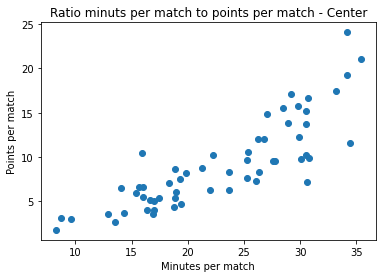

In [1619]:
plt.scatter(df['MIN']/df['Games Played'],df['PTS']/df['Games Played'])
plt.title("Ratio minuts per match to points per match - Center")
plt.xlabel("Minutes per match")
plt.ylabel("Points per match")
plt.subplot

Text(0, 0.5, 'Age')

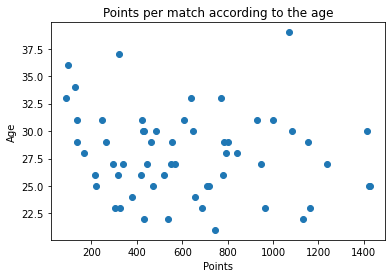

In [1620]:
plt.scatter(df['PTS'],df['Age'])
plt.title("Points per match according to the age")
plt.xlabel("Points")
plt.ylabel("Age")
   

Text(0, 0.5, 'EFF')

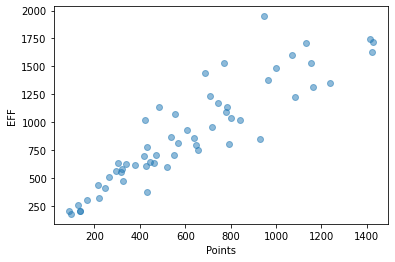

In [1621]:
plt.scatter( df['PTS'],df["EFF"], alpha=0.5)
plt.xlabel('Points')
plt.ylabel('EFF')

During analysis eff rate (x) was displayed with points (y).
According to the graph, center players doesn't score as many points as shooters for example.

In [1622]:
df.describe()

,Games Played,MIN,PTS,FGM,FGA,FG%,3PM,3PA,3P%,FTM,...,BLK,TOV,PF,EFF,AST/TOV,STL/TOV,Age,Height,Weight,BMI
count,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,...,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000,58.000000
mean,65.913793,1538.810345,617.396552,250.551724,486.017241,52.175862,4.948276,15.103448,12.084483,111.344828,...,70.741379,89.155172,156.068966,895.258621,0.925172,0.442586,27.879310,207.931034,114.292241,26.456829
std,13.892172,640.384683,356.313480,145.484812,289.020335,5.803578,13.478277,37.379368,15.975396,79.241924,...,44.460730,45.869686,55.659952,457.058696,0.523474,0.217744,3.875599,3.249087,6.164035,1.712727
min,29.000000,383.000000,87.000000,36.000000,62.000000,42.900000,0.000000,0.000000,0.000000,12.000000,...,14.000000,12.000000,53.000000,178.000000,0.180000,0.050000,21.000000,200.000000,102.600000,23.829293
25%,59.250000,1124.500000,329.750000,141.750000,279.500000,47.575000,0.000000,0.000000,0.000000,51.250000,...,35.500000,53.750000,121.250000,586.750000,0.560000,0.302500,25.000000,205.625000,110.250000,25.243927
50%,69.500000,1471.000000,554.500000,224.500000,427.000000,51.450000,0.000000,2.000000,0.000000,102.500000,...,56.500000,95.500000,162.000000,807.000000,0.775000,0.390000,27.500000,207.500000,114.300000,26.234384
75%,76.000000,2084.250000,799.250000,319.500000,652.750000,56.100000,2.000000,6.750000,27.775000,153.750000,...,98.750000,109.000000,201.500000,1211.500000,1.107500,0.580000,30.000000,210.000000,118.687500,27.379927
max,82.000000,2820.000000,1428.000000,631.000000,1206.000000,71.000000,63.000000,175.000000,50.000000,423.000000,...,189.000000,254.000000,285.000000,1949.000000,2.540000,1.040000,39.000000,215.000000,130.050000,31.275720


In [1623]:
simulation_data = { 'N': len(df["PTS"]), "points": np.linspace(df["PTS"].min(),df["PTS"].max(),num=58) }
R = 1000


In [1624]:
model = CmdStanModel(stan_file='linear_regression.stan')

simulation = model.sample(data=simulation_data, iter_sampling = R, 
                             iter_warmup = 1000,
                             fixed_param=False,
                             chains = 4,
                             seed = 31052022)



INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |██████████| 00:00 Sampling completed
chain 2 |██████████| 00:00 Sampling completed
chain 3 |██████████| 00:00 Sampling completed
chain 4 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


In [1625]:
simulation.summary()

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,0.00,NaN,0.00,0.00,0.0,0.0,NaN,NaN,NaN
alpha,590.00,3.4000,220.00,220.00,590.0,920.0,4200.0,22000.0,1.0
beta,0.98,0.0027,0.17,0.82,1.0,1.2,4000.0,22000.0,1.0
sigma,100.00,0.8200,49.00,18.00,100.0,180.0,3600.0,20000.0,1.0
eff[1],673.00,3.9000,246.00,262.00,679.0,1069.0,3973.0,21474.0,1.0
...,...,...,...,...,...,...,...,...,...
eff[54],1897.00,6.1000,385.00,1429.00,1930.0,2375.0,4012.0,21688.0,1.0
eff[55],1917.00,6.1000,387.00,1448.00,1950.0,2395.0,4037.0,21821.0,1.0
eff[56],1938.00,6.1000,392.00,1462.00,1967.0,2428.0,4080.0,22054.0,1.0


<h4>Prior for linear model</h4>

Research showed that approximatly center player are scoring about 700 points per season (center which played more than 300 minutes). Linear and quadratic models uses preditors - points. For the linear model the priors were selected based on observations

In [1626]:
alpha_linear_ppc = simulation.stan_variable('alpha')
beta_linear_ppc = simulation.stan_variable('beta')
sigma_linear_ppc = simulation.stan_variable('sigma')
eff_linear_pcc = simulation.stan_variable('eff')

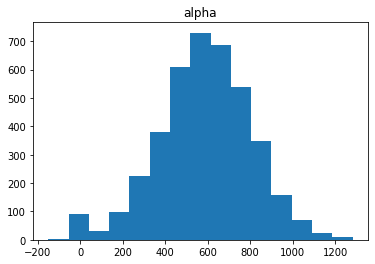

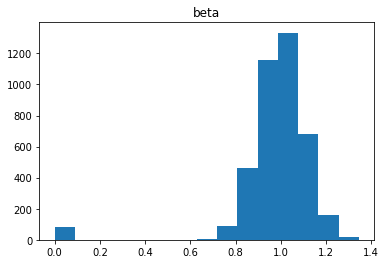

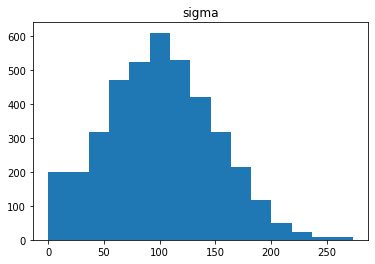

In [1627]:
for signs in ['alpha', 'beta', 'sigma']:
    plt.hist(simulation.stan_variable(signs), bins=15)
    plt.title(signs)
    plt.show()

Text(0, 0.5, 'eff')

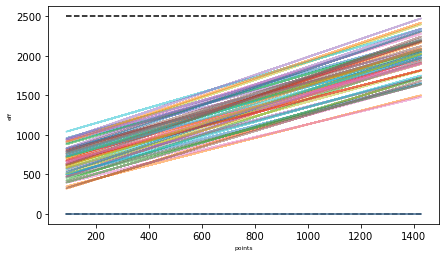

In [1628]:
fig, axes = plt.subplots(1,1, figsize = (7,4))
axes.hlines([0, 2500], xmin = df['PTS'].min(), 
            xmax = df['PTS'].max(), linestyle = '--', color = 'black')
for i in range(60):
    axes.plot(df['PTS'], 
              alpha_linear_ppc[i] + beta_linear_ppc[i]*df['PTS'], alpha=0.5)
axes.set_xlabel('points', fontsize = 6)
axes.set_ylabel('eff', fontsize = 6)

Prior seems to fit the actual data, it covers all data range.

<h2>Linear model - posterior</h2>

In [1629]:
with open('gen_lin.stan', 'r') as file:
    print(file.read())

data {
   int N;
   vector[N] points;
   real effs[N];
}

parameters {
   real alpha;
   real beta;
   real <lower=0> sigma;
}

transformed parameters {
   vector[N] mu = points*beta+alpha;
}

model {
   alpha ~ normal(600, 200);
	beta ~ normal(2, 0.5);
   sigma ~ normal(300, 50);
   effs ~ normal(mu, sigma);
}

generated quantities {
   array [N] real eff;
   vector[N] log_lik;
   array[N] real y_hat;

   for (i in 1:N) {
       eff[i] = normal_rng(mu[i], sigma);
       log_lik[i] = normal_lpdf(eff[i] | mu[i], sigma);
      y_hat[i] = normal_rng(mu[i], sigma);

   }
}


In [1630]:
simulation_data = { 'N': len(df),  'effs': df['EFF'], "points": df["PTS"]  }


In [1631]:
model_pos_linear = CmdStanModel(stan_file='gen_lin.stan')
simulation_pos = model_pos_linear.sample(data=simulation_data)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |          | 00:00 Status


chain 1 |████      | 00:00 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


No problems with samplings

In [1632]:
alpha_linear_fit = simulation_pos.stan_variable('alpha')
beta_linear_fit = simulation_pos.stan_variable('beta')
sigma_linear_fit = simulation_pos.stan_variable('sigma')
eff_linear_fit = simulation_pos.stan_variable('eff')

In [1633]:
simulation_pos.diagnose()

'Processing csv files: C:\\Users\\macie\\AppData\\Local\\Temp\\tmpq900vzzx\\gen_lin-20220621020523_1.csv, C:\\Users\\macie\\AppData\\Local\\Temp\\tmpq900vzzx\\gen_lin-20220621020523_2.csv, C:\\Users\\macie\\AppData\\Local\\Temp\\tmpq900vzzx\\gen_lin-20220621020523_3.csv, C:\\Users\\macie\\AppData\\Local\\Temp\\tmpq900vzzx\\gen_lin-20220621020523_4.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.\n'

In [1634]:
az.summary(simulation_pos)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,200.114,53.658,97.498,301.361,1.313,0.928,1700.0,1471.0,1.0
beta,1.138,0.077,0.994,1.285,0.002,0.001,1651.0,1699.0,1.0
sigma,218.337,21.180,179.783,257.571,0.440,0.314,2379.0,2131.0,1.0
mu[0],1515.835,52.103,1417.070,1612.860,1.012,0.717,2666.0,2445.0,1.0
mu[1],1431.610,47.435,1344.060,1522.430,0.881,0.624,2914.0,2563.0,1.0
...,...,...,...,...,...,...,...,...,...
y_hat[53],686.113,221.805,271.639,1092.730,3.439,2.443,4159.0,3972.0,1.0
y_hat[54],1418.273,219.094,1020.490,1851.150,3.501,2.476,3910.0,3988.0,1.0
y_hat[55],1095.696,218.932,672.358,1500.870,3.477,2.472,3974.0,3816.0,1.0
y_hat[56],1076.053,222.456,639.212,1470.010,3.515,2.487,4003.0,3632.0,1.0


Text(0, 0.5, 'eff')

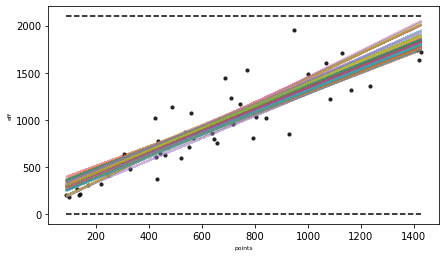

In [1635]:
fig, axes = plt.subplots(1,1, figsize = (7,4))
axes.hlines([0, 2100], xmin = df['PTS'].min(), 
            xmax = df['PTS'].max(), linestyle = '--', color = 'black')
for i in range(60):
    axes.plot(df['PTS'], 
              alpha_linear_fit[i] + beta_linear_fit[i]*df['PTS'], alpha=0.5)
axes.scatter(df['PTS'], df['EFF'], 
             color = 'black', alpha = 0.8, s=10)
axes.set_xlabel('points', fontsize = 6)
axes.set_ylabel('eff', fontsize = 6)

The parameters looks like normal distribution. The data is consistent with prior generation. Posterior is inline with actual data.

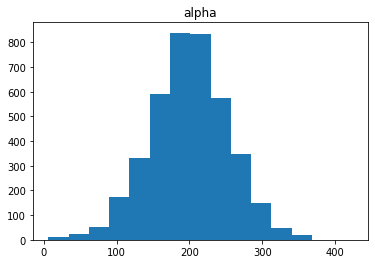

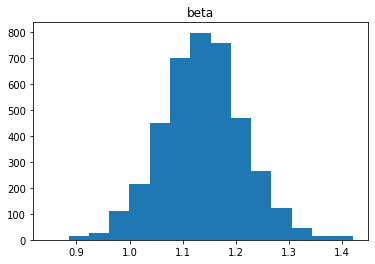

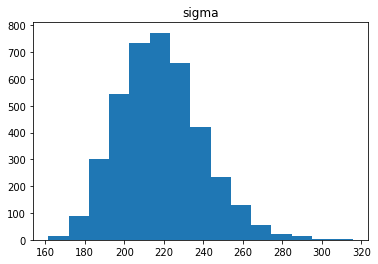

In [1636]:
for var in ['alpha', 'beta', 'sigma']:
    plt.hist(simulation_pos.stan_variable(var), bins=15)
    plt.title(var)
    plt.show()

Posterior is similar to prior, but the curves are closer to each other

<h2>Quadratic prior</h2>

The prior were selected exactly the same as in linear model, but according to the values, gamma have to have  negative values. As we know in some point the function will slow down or event tend to stop. That's why our gamma should have negative values

In [1637]:
model_squared = CmdStanModel(stan_file = 'quadratic.stan')

INFO:cmdstanpy:found newer exe file, not recompiling


In [1638]:
simulation_data = { 'N': len(df["PTS"]), "points": np.linspace(df["PTS"].min(),df["PTS"].max(),num=58) }
simulation_squared = model_squared.sample(data=simulation_data, 
                                          iter_sampling=R, 
                                          refresh=R, 
                                          iter_warmup=0, 
                                          chains=1, 
                                          fixed_param=True)

INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.


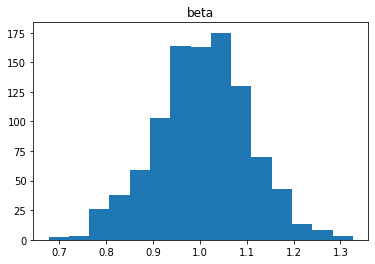

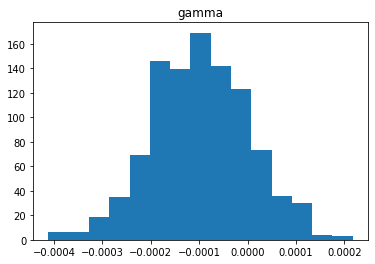

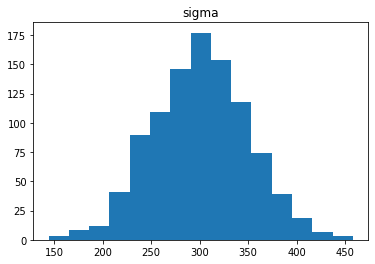

In [1639]:
for signs in ['beta', 'gamma', 'sigma']:
    plt.hist(simulation_squared.stan_variable(signs), bins=15)
    plt.title(signs)
    plt.show()

Histograms looks like normal distribution

In [1640]:
beta_quad_ppc = simulation_squared.stan_variable('beta')
gamma_quad_ppc = simulation_squared.stan_variable('gamma')
eff_quad_ppc = simulation_squared.stan_variable('eff')

Text(0, 0.5, 'eff')

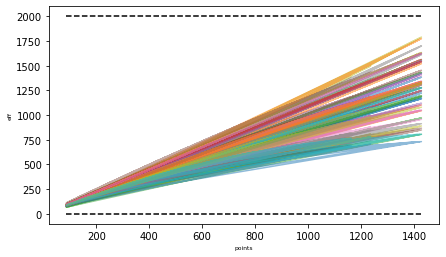

In [1641]:
fig, axes = plt.subplots(1,1, figsize = (7,4))
axes.hlines([0, 2000], xmin = df['PTS'].min(), 
            xmax = df['PTS'].max(), linestyle = '--', color = 'black')
for i in range(60):
    axes.plot(df['PTS'], 
                 gamma_quad_ppc[i]*np.square(df['PTS']) + beta_quad_ppc[i]*df['PTS'], alpha=0.5)
axes.set_xlabel('points', fontsize = 6)
axes.set_ylabel('eff', fontsize = 6)

<h2>Quadratic Posterior</h2>

In [1652]:
with open('gen_quad.stan', 'r') as file:
    print(file.read())

data {
	int N;
	vector[N] points;
	real effs[N];
}

parameters {
	real alpha;
	real beta;
	real gamma;
	real<lower=0> sigma;
}

transformed parameters {
	vector[N] mu = square(points)*gamma + points*beta;
}

model {
	beta ~ normal(1,0.1); 
	sigma ~ normal(300, 50);
	gamma ~ normal(-0.0001, 0.0001);
	effs ~ normal(mu, sigma);
}

generated quantities {
	real eff[N];
	vector[N] log_lik;
	array[N] real y_hat;

	for (i in 1:N){
		eff[i] = normal_rng(mu[i], sigma);
		log_lik[i] = normal_lpdf(effs[i] | mu[i], sigma);
		y_hat[i] = normal_rng(mu[i], sigma);
	}
}


In [1643]:
simulation_data_pos_squared = { 'N': len(df), "points": df["PTS"], 'effs': df['EFF']  }


In [1644]:
model_squared_p = CmdStanModel(stan_file='gen_quad.stan')
simulation_pos_squared = model_squared_p.sample(data=simulation_data_pos_squared)

INFO:cmdstanpy:compiling stan file C:\Users\macie\OneDrive\Pulpit\All\Studia\AIR_2022\Data_analytics\Data_Analytics\Data_Analytics\Project\gen_quad.stan to exe file C:\Users\macie\OneDrive\Pulpit\All\Studia\AIR_2022\Data_analytics\Data_Analytics\Data_Analytics\Project\gen_quad.exe
INFO:cmdstanpy:compiled model executable: C:\Users\macie\OneDrive\Pulpit\All\Studia\AIR_2022\Data_analytics\Data_Analytics\Data_Analytics\Project\gen_quad.exe
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/macie/OneDrive/Pulpit/All/Studia/AIR_2022/Data_analytics/Data_Analytics/Data_Analytics/Project/gen_quad.hpp C:/Users/macie/OneDrive/Pulpit/All/Studia/AIR_2022/Data_analytics/Data_Analytics/Data_Analytics/Project/gen_quad.stan
Warning in 'C:/Users/macie/OneDrive/Pulpit/All/Studia/AIR_2022/Data_analytics/Data_Analytics/Data_Analytics/Project/gen_quad.stan', line 4, column 1: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Sta


INFO:cmdstanpy:CmdStan done processing.


In [1645]:
beta_squared_fit = simulation_pos_squared.stan_variable('beta')
gamma_squared_fit = simulation_pos_squared.stan_variable('gamma')
eff_squared_fit = simulation_pos_squared.stan_variable('eff')


Text(0, 0.5, 'eff')

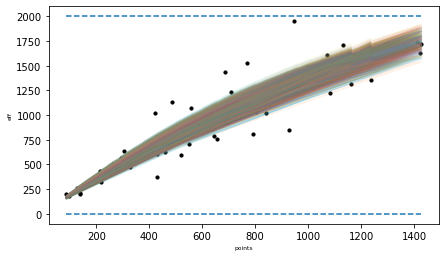

In [1646]:
fig, axes = plt.subplots(1,1, figsize = (7,4))
axes.hlines([0, 2000], xmin = df['PTS'].min(), 
            xmax = df['PTS'].max(), linestyle = '--')
for i in range(200):
    axes.plot(df['PTS'], 
                gamma_squared_fit[i]*np.square(df['PTS']) + beta_squared_fit[i]*df['PTS'] , alpha=0.1)
axes.scatter(df['PTS'], df['EFF'], 
             color = 'black', alpha = 1, s=10)
axes.set_xlabel('points', fontsize = 6)
axes.set_ylabel('eff', fontsize = 6)

The posterior curves are closer to each other. It seems like coefficients were selected quite nice. But the results from posterior anylisys are a little bit diffrent. The diffrence could be made by increasing the range of axes.

Both results are similar.

<h2>Model Comparison</h2>

In [1647]:
fit_linear = az.from_cmdstanpy(posterior = simulation_pos, log_likelihood = 'log_lik', 
                                 posterior_predictive='y_hat' )


fit_quadratic = az.from_cmdstanpy(posterior=simulation_pos_squared, log_likelihood = 'log_lik', 
                                    posterior_predictive='y_hat')


c:\Users\macie\anaconda3\envs\data\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Text(0.5, 1.0, 'WAIC comparision')

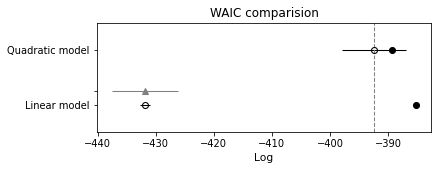

In [1648]:

compare_dict = {'Linear model': fit_linear,'Quadratic model': fit_quadratic}
model_compare_waic = az.compare(compare_dict)
az.plot_compare(model_compare_waic)
plt.title('WAIC comparision')


In [1650]:
model_compare_waic

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Quadratic model,0,-392.416456,3.120237,0.000000,1.000000e+00,5.531107,0.000000,False,log
Linear model,1,-431.829708,46.627728,39.413252,1.230660e-11,0.927785,5.721884,True,log


c:\Users\macie\anaconda3\envs\data\lib\site-packages\arviz\stats\stats.py:811: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Text(0.5, 1.0, 'LOO comparison')

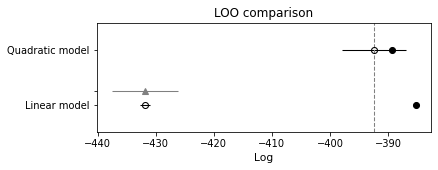

In [1649]:
model_compare_loo = az.compare(compare_dict, ic="loo", method="stacking", scale="log")
az.plot_compare(model_compare_loo)
plt.title('LOO comparison')


In [1651]:
model_compare_loo

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
Quadratic model,0,-392.416456,3.120237,0.000000,1.000000e+00,5.531107,0.000000,False,log
Linear model,1,-431.829708,46.627728,39.413252,1.230660e-11,0.927785,5.721884,True,log


As it looks for models comparision, clearly the only winner with both cases is quadratic model. There isn't overlap and also there wasn't any warnings. We can observe that the diffrence is really small.